**Projekt: Analiza Sentymentu**

Autor: Przemysław Brzozowski s16840

Projekt bazuje na danych z twittera z tagu: #Eurovision2023. Dane zostały pobrane 14 Maja

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Etap 1A

##Instalacja

In [1]:
#Poniższe ustawienie encoding na utf-8 naprawia błąd przy instalacji plot_keras_history
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:
!pip install -U spacy -q
!pip install transformers==4.28.0
!python -m spacy download en_core_web_lg -q
!pip install plot_keras_history -q
!pip install -U datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 42.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.1 MB/s eta 0:00:00
2023-05-22 23:09:01.102629: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 23:09:02.546536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-22 23:09:04.522068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negat

In [3]:
import transformers
from transformers import pipeline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from re import sub
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

import logging
import numpy as np

import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences, to_categorical

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

##Ładowanie danych

In [6]:
folder_path='/content/drive/MyDrive/'
file_path=f'{folder_path}Tweets_Eurovision2023.csv'
df=pd.read_csv(file_path).dropna().drop_duplicates()
df.sample(5)

,tweet created at,tweet id,tweetText
1867,2023-05-14 14:54:32+00:00,1657761316537237505,@TribesBritannia You should share this. @WME ...
17206,2023-05-13 23:16:19+00:00,1657525206993256448,Bullshit. Well done Finland &amp my favourites...
19382,2023-05-13 23:12:11+00:00,1657524166789152771,*sigh* #Eurovision2023
13835,2023-05-13 23:36:15+00:00,1657530223217319937,Mid song and mid performance. Disappointing #E...
16824,2023-05-13 23:17:36+00:00,1657525532202868737,"Europe, you've failed me once again #Eurovisio..."


In [7]:
df.shape

(20000, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet created at  20000 non-null  object
 1   tweet id          20000 non-null  int64 
 2   tweetText         20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 625.0+ KB


##Klasyfikacja Zero-shot: Facebook bart-large-mnli

In [ ]:
#Define pipeline
classifier = pipeline(task="zero-shot-classification",
                      model="facebook/bart-large-mnli",
                      device=0)

###Klasyfikacja (zajmuje ok 40 minut)

In [ ]:
sequences = df['tweetText'].to_list()
candidate_labels = ["positive","neutral","negative"]
hypothesis_template="The sentiment of this text is {}"
hf_prediction = classifier(sequences,candidate_labels,hypothesis_template=hypothesis_template)

In [ ]:
hf_prediction = pd.DataFrame(hf_prediction)
hf_prediction.head()

,sequence,labels,scores
0,Flying over #Liverpool while the city was host...,"[negative, positive, neutral]","[0.49177873134613037, 0.299344539642334, 0.208..."
1,Do you wanna see me cry???#Eurovision2023 #Eur...,"[negative, neutral, positive]","[0.8568503260612488, 0.09965509176254272, 0.04..."
2,"Sadly, Loreen passed from being the best ESC w...","[negative, neutral, positive]","[0.9578991532325745, 0.027110090479254723, 0.0..."
3,After the thrills of #EUROVISION2023 a more co...,"[positive, neutral, negative]","[0.5155931115150452, 0.29178184270858765, 0.19..."
4,which was more culturally significant the rena...,"[neutral, negative, positive]","[0.4344634711742401, 0.3162793517112732, 0.249..."


In [ ]:
hf_prediction['hf_prediction'] = hf_prediction['labels'].apply(lambda x: x[0])
hf_prediction['hf_prediction'] = hf_prediction['hf_prediction'].map({'positive':1,'neutral':0,'negative':-1})
hf_prediction['hf_predicted_score']= hf_prediction['scores'].apply(lambda x: x[0])
hf_prediction = hf_prediction.drop(['labels','scores'],axis=1)

In [ ]:
hf_prediction = pd.DataFrame(hf_prediction)
hf_prediction.sample(5)

,sequence,hf_prediction,hf_predicted_score
741,One thing I thought about Mae's result. That r...,-1,0.627394
12051,idk on tuesday and thursday yall were saying h...,-1,0.903557
19692,#Eurovision2023 congrats to the winner,1,0.970900
14524,#EUROVISION2023 you were amazing. Sweden winni...,1,0.900694
2674,To those saying Loreen shouldnt have been allo...,-1,0.859462


In [ ]:
hf_prediction.groupby(['hf_prediction']).count()

,sequence,hf_predicted_score
hf_prediction,,
-1,9678,9678
0,445,445
1,9877,9877


In [ ]:
predicted_df=df
predicted_df['predicted']=hf_prediction["hf_prediction"]

In [ ]:
predicted_df.head()

,tweet created at,tweet id,tweetText,predicted
0,2023-05-14 20:05:34+00:00,1657839592010047490,Flying over #Liverpool while the city was host...,-1
1,2023-05-14 20:05:27+00:00,1657839561429381120,Do you wanna see me cry???#Eurovision2023 #Eur...,-1
2,2023-05-14 20:05:15+00:00,1657839510133022720,"Sadly, Loreen passed from being the best ESC w...",-1
3,2023-05-14 20:05:07+00:00,1657839480575762441,After the thrills of #EUROVISION2023 a more co...,1
4,2023-05-14 20:04:13+00:00,1657839253508816898,which was more culturally significant the rena...,0


In [ ]:
predicted_df.to_csv('hf_predictions.csv',index=False)

###Ładowanie z pliku (dla przyspieszenia prezentacji)

In [9]:
file_path=f'{folder_path}hf_predictions.csv'
predicted_df=pd.read_csv(file_path)
predicted_df.sample(5)

,tweet created at,tweet id,tweetText,predicted
6511,2023-05-14 09:23:07+00:00,1657677913377107979,Time to watch #Eurovision2023 again. This time...,1
12752,2023-05-13 23:50:46+00:00,1657533879144660993,Loreen fucking did THAT! #EUROVISION2023 https...,-1
8804,2023-05-14 06:05:42+00:00,1657628230919094273,There's no point calling their support because...,-1
13513,2023-05-13 23:39:23+00:00,1657531013789020160,The problem with jury points is that I dont ca...,-1
4830,2023-05-14 10:53:30+00:00,1657700659137859584,Last night feels like a brilliant but very wei...,1


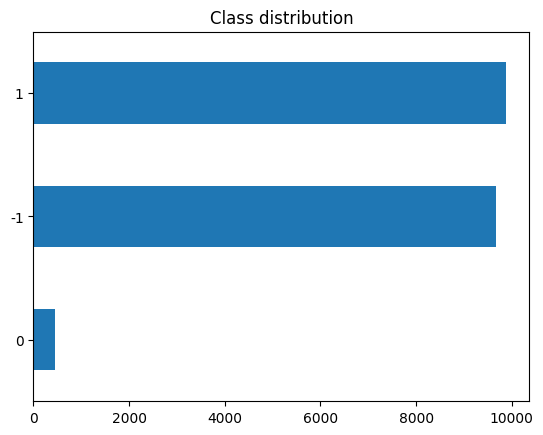

In [ ]:
predicted_df.predicted.value_counts(ascending=True).plot.barh()
plt.title('Class distribution')
plt.show()

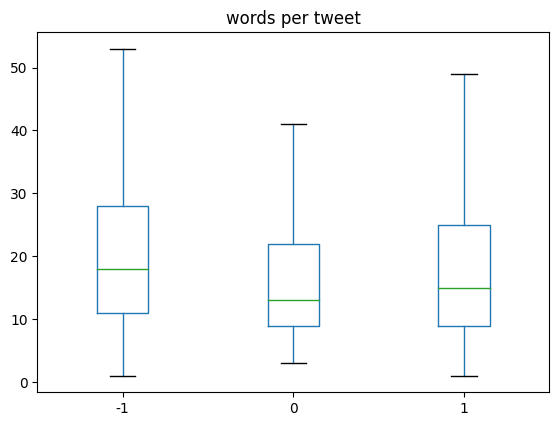

In [ ]:
plot_df=predicted_df
plot_df['words per tweet']=predicted_df['tweetText'].str.split().apply(len)
plot_df.boxplot('words per tweet', by='predicted',grid=False,showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

###Czyszczenie danych

In [10]:
nlp=spacy.load("en_core_web_lg",disable=['ner','parser'])
nlp.add_pipe('sentencizer')

In [11]:
def clean_text(text):
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r'((www.[^\s]+)|(https?://[^\s]+))','',text)
    text = sub(r"'", " ", text)
    text = sub(r"^@?(\w){1,15}$", " ", text)
    text = sub(r"#[A-Za-z0-9_]+"," ",text)
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^a-z0-9]"," ", text)

    return text

In [12]:
predicted_df.tweetText = predicted_df.tweetText.apply(lambda x: clean_text(x))

file_model = predicted_df.copy()
file_model = file_model[file_model.tweetText.str.len()>1]
file_model.sample(5)

,tweet created at,tweet id,tweetText,predicted
5812,2023-05-14 09:58:08+00:00,1657686725479522307,is not about singing it s a political spect...,-1
12406,2023-05-13 23:57:27+00:00,1657535560590794754,get real twitter followers,1
4590,2023-05-14 11:08:07+00:00,1657704337886388224,if i see another finland deserved to win swed...,-1
4122,2023-05-14 11:39:54+00:00,1657712336361213953,we re coming soon hurry up follow for updates ...,1
7279,2023-05-14 08:32:44+00:00,1657665234742435844,finland were robbed thats all i have to say o...,-1


In [13]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words,text.split()))

def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

predicted_df.tweetText = predicted_df.tweetText.apply(remove_stopwords)
predicted_df.tweetText = predicted_df.tweetText.apply(lemmatize)
predicted_df.sample(5)

,tweet created at,tweet id,tweetText,predicted
1357,2023-05-14 16:09:33+00:00,1657780194818637826,look entry irish spotify viral 50 chart 1 2 3 ...,1
11714,2023-05-14 00:13:55+00:00,1657539702734352385,make sob stop rn,-1
11330,2023-05-14 00:28:40+00:00,1657543416140447746,yes funny coincidence year sweden hosting song...,1
6476,2023-05-14 09:25:01+00:00,1657678390667747329,morning eurovision like huge alcohol party,-1
6514,2023-05-14 09:23:00+00:00,1657677883253436416,t stop think moment yesterday,1


###Word Cloud

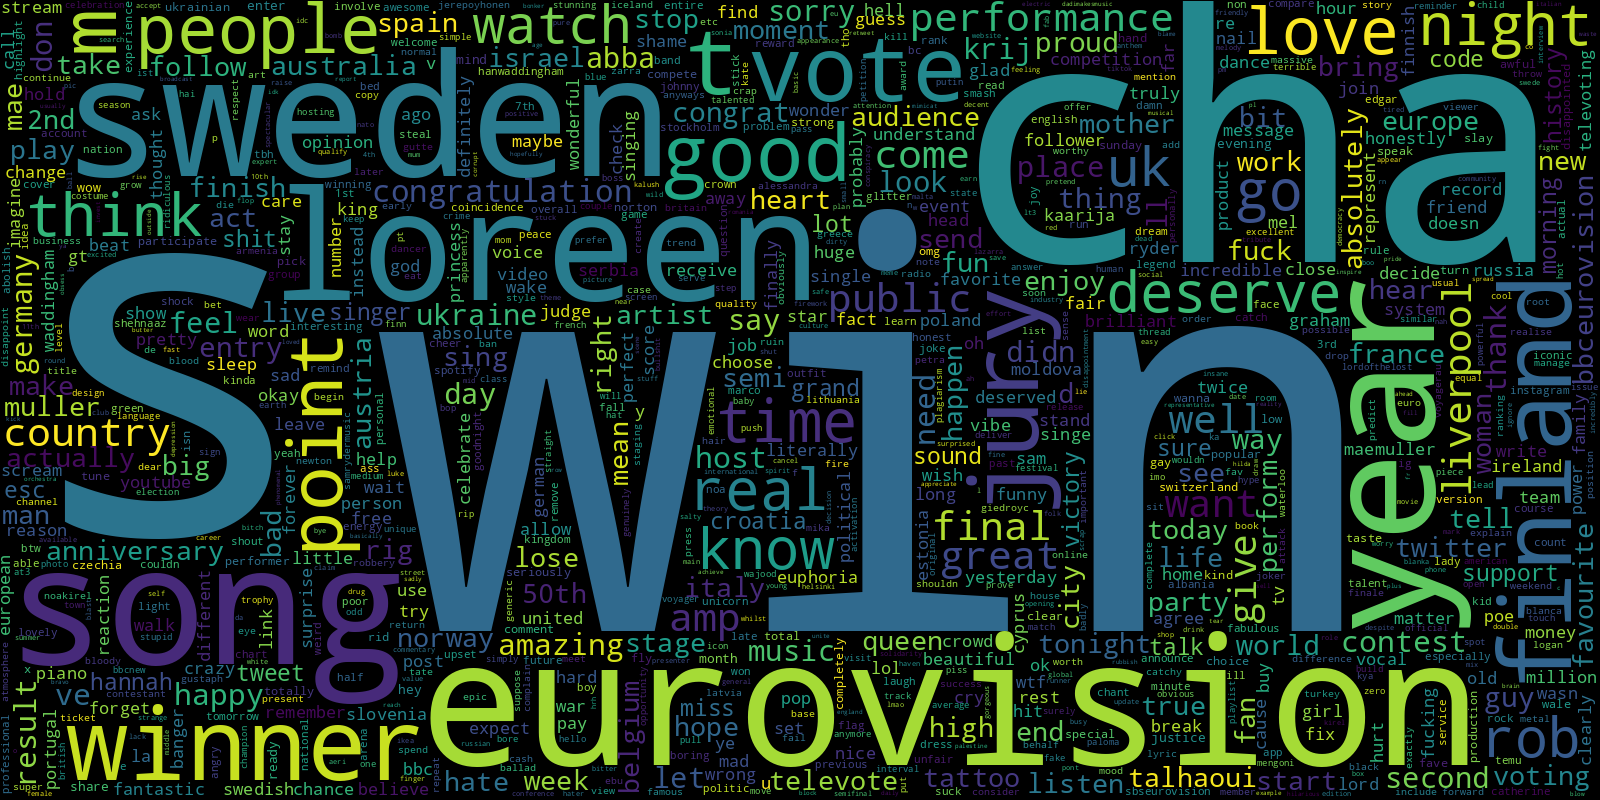

In [ ]:
text = ' '.join(predicted_df.tweetText)
wc=WordCloud(max_words=1000,width = 1600,height = 800,collocations=False).generate(text)
wc.to_image()

#Etap 2: Classic ML

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(predicted_df.tweetText, predicted_df.predicted, test_size=0.25,stratify=predicted_df.predicted,random_state=42)

In [ ]:
y_train.value_counts()

 1    7408
-1    7258
 0     334
Name: predicted, dtype: int64

In [ ]:
y_test.value_counts()

 1    2469
-1    2420
 0     111
Name: predicted, dtype: int64

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=500000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [ ]:
len(vectorizer.get_feature_names_out())

90381

In [ ]:
X_train=vectorizer.transform(X_train)
X_test=vectorizer.transform(X_test)

In [ ]:
def plot_conf_matrix(y_test,y_pred):
  cf_matrix=confusion_matrix(y_test,y_pred)
  #plot_confusion_matrix(cf_matrix,classes=["Positive","Neutral","Negative"])
  plt.figure(figsize=(5,4))
  sns.heatmap(cf_matrix, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

In [ ]:
def print_roc(y_test,y_pred):
  fpr, tpr = roc_curve(y_test, y_pred, pos_label=1)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC CURVE')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
def model_test(model,X_train,X_test,y_train,y_test):
  model.fit(X_train,y_train)
  y_pred=model.predict(X_test)
  print(classification_report(y_test,y_pred))
  print("Accuracy: ",accuracy_score(y_test,y_pred))
  plot_conf_matrix(y_test,y_pred)
  print_roc(y_test,y_pred)

##Bernoulli Naive Bayes Model

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.81      0.58      0.67      2420
           0       0.00      0.00      0.00       111
           1       0.66      0.88      0.76      2469

    accuracy                           0.72      5000
   macro avg       0.49      0.49      0.48      5000
weighted avg       0.72      0.72      0.70      5000

Accuracy:  0.7156


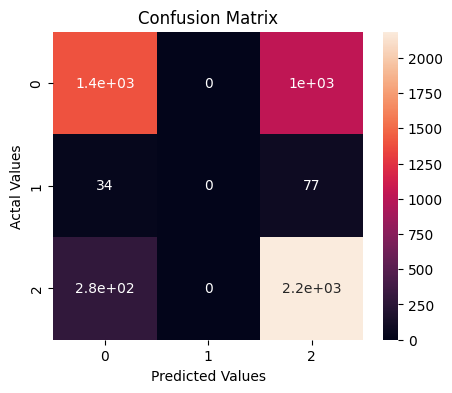

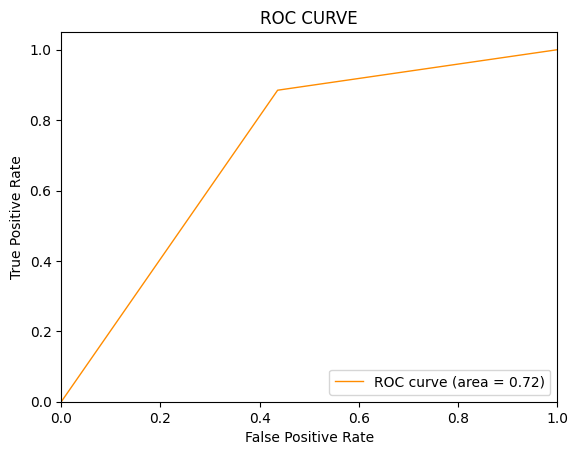

In [ ]:
model_test(BernoulliNB(),X_train,X_test,y_train,y_test)

##SVC Model

              precision    recall  f1-score   support

          -1       0.76      0.78      0.77      2420
           0       0.62      0.07      0.13       111
           1       0.77      0.78      0.77      2469

    accuracy                           0.76      5000
   macro avg       0.71      0.54      0.56      5000
weighted avg       0.76      0.76      0.75      5000

Accuracy:  0.7602


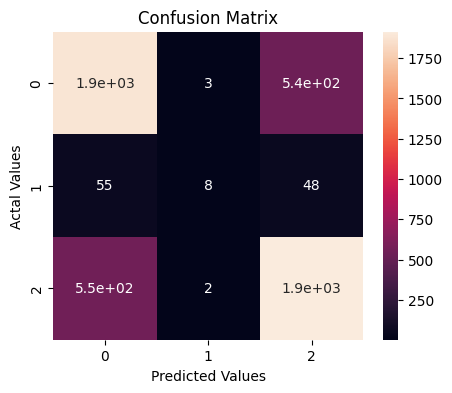

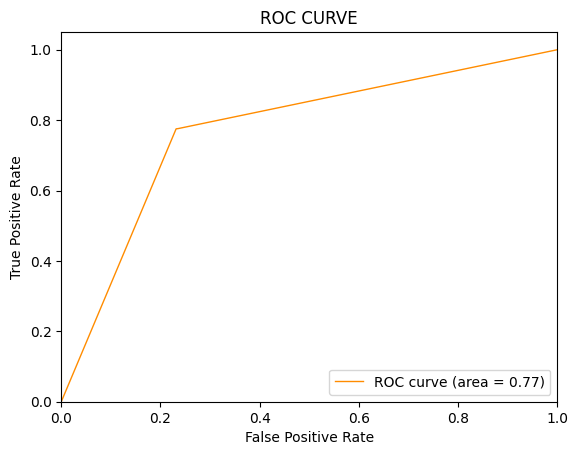

In [ ]:
model_test(LinearSVC(),X_train,X_test,y_train,y_test)

##Logistic Regression Model

              precision    recall  f1-score   support

          -1       0.75      0.78      0.77      2420
           0       0.67      0.04      0.07       111
           1       0.77      0.77      0.77      2469

    accuracy                           0.76      5000
   macro avg       0.73      0.53      0.54      5000
weighted avg       0.76      0.76      0.75      5000

Accuracy:  0.7608


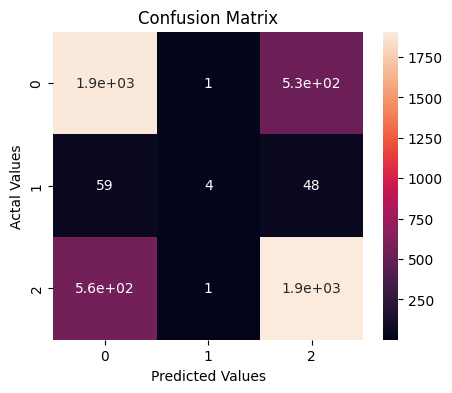

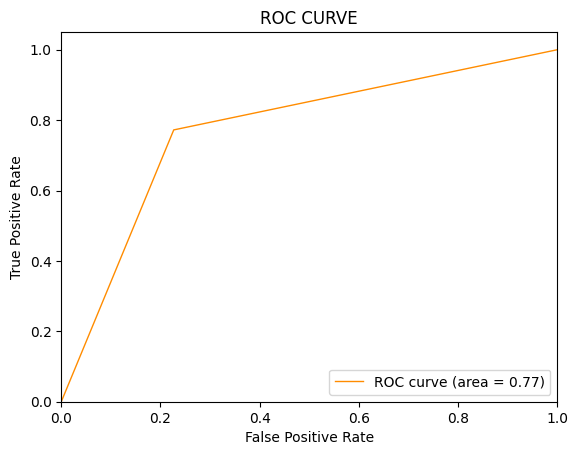

In [ ]:
model_test(LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1),X_train,X_test,y_train,y_test)

#Etap 3: Neural Model

##Ładowanie danych

In [ ]:
max_words=10000
max_len=200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(predicted_df.tweetText)
tweet_sequences=tokenizer.texts_to_sequences(predicted_df.tweetText)
padded_tweets = pad_sequences(tweet_sequences,maxlen=max_len)
print(padded_tweets)

[[   0    0    0 ...   67   46 7030]
 [   0    0    0 ...    0  403  299]
 [   0    0    0 ...   64  404 3322]
 ...
 [   0    0    0 ...    6    1   25]
 [   0    0    0 ...    9 1196   50]
 [   0    0    0 ...  202 3223  619]]


In [ ]:
tweet_labels=to_categorical(predicted_df.predicted,num_classes=3)

In [ ]:
X_train2,X_test2,y_train2,y_test2 = train_test_split(padded_tweets,tweet_labels,test_size=0.2,stratify=tweet_labels,random_state=42)

In [ ]:
padded_tweets.shape

(20000, 200)

In [ ]:
tweet_labels.shape

(20000, 3)

In [ ]:
from plot_keras_history import show_history, plot_history

def showPlot_history(history):
  show_history(history)
  plot_history(history)
  plt.close()

##Testowanie różnych modeli.
Testuję 3 różne modele z różnymi parametrami w celu poprawienia parametru dokładności. Wszystkie modele, mimo zastosowania różnych parametrów, uzyskały średni wynik Accuracy ok. 77%

###Model 1:

In [ ]:
def my_model1(model_name,max_words,output_dim,input_len,lstm_units,lstm_dropout,dense_units,optimizer,epochs):
  my_model = Sequential()
  my_model.add(layers.Embedding(max_words, output_dim, input_length=input_len))
  my_model.add(layers.Bidirectional(layers.LSTM(lstm_units,dropout=lstm_dropout)))
  my_model.add(layers.Dense(dense_units,activation='softmax'))

  my_model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

  checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
  history = my_model.fit(X_train2, y_train2, epochs=epochs,validation_data=(X_test2, y_test2),callbacks=[checkpoint])
  #show plot
  showPlot_history(history)

  # Print out the accuracy of the model on the test set
  model_scores = my_model.evaluate(X_test2, y_test2, verbose=0)
  print("Model loss on the test dataset: {0:.2f}%".format(model_scores[0]*100))
  print("Model accuracy on the test dataset: {0:.2f}%".format(model_scores[1]*100))

Epoch 1/60
499/500 [============================>.] - ETA: 0s - loss: 0.8822 - accuracy: 0.4874
Epoch 1: val_accuracy improved from -inf to 0.63275, saving model to /content/drive/MyDrive/best_model1.hdf5
500/500 [==============================] - 14s 21ms/step - loss: 0.8819 - accuracy: 0.4873 - val_loss: 0.7801 - val_accuracy: 0.6327
Epoch 2/60
499/500 [============================>.] - ETA: 0s - loss: 0.7694 - accuracy: 0.6008
Epoch 2: val_accuracy did not improve from 0.63275
500/500 [==============================] - 10s 20ms/step - loss: 0.7693 - accuracy: 0.6009 - val_loss: 0.7555 - val_accuracy: 0.6130
Epoch 3/60
500/500 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.6249
Epoch 3: val_accuracy improved from 0.63275 to 0.64550, saving model to /content/drive/MyDrive/best_model1.hdf5
500/500 [==============================] - 9s 19ms/step - loss: 0.7399 - accuracy: 0.6249 - val_loss: 0.7246 - val_accuracy: 0.6455
Epoch 4/60
500/500 [======================

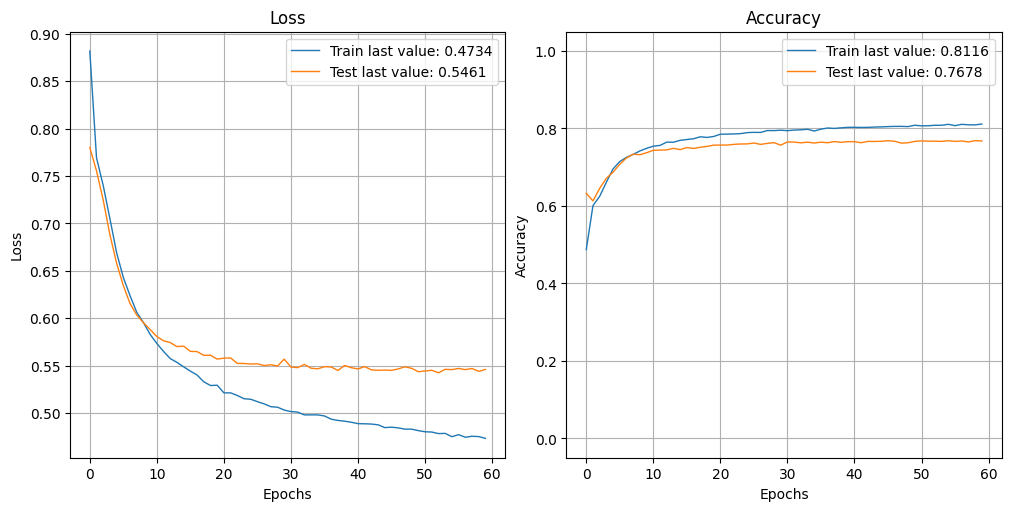

Model loss on the test dataset: 54.61%
Model accuracy on the test dataset: 76.78%


In [ ]:
my_model1(f"{folder_path}best_model1.hdf5",max_words,40,max_len,20,0.6,3,keras.optimizers.RMSprop(learning_rate=0.0001),60)

Epoch 1/50
500/500 [==============================] - ETA: 0s - loss: 0.7826 - accuracy: 0.5452
Epoch 1: val_accuracy improved from -inf to 0.58100, saving model to /content/drive/MyDrive/best_model2.hdf5
500/500 [==============================] - 17s 28ms/step - loss: 0.7826 - accuracy: 0.5452 - val_loss: 0.7560 - val_accuracy: 0.5810
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.6168
Epoch 2: val_accuracy improved from 0.58100 to 0.66350, saving model to /content/drive/MyDrive/best_model2.hdf5
500/500 [==============================] - 13s 25ms/step - loss: 0.7349 - accuracy: 0.6168 - val_loss: 0.6995 - val_accuracy: 0.6635
Epoch 3/50
499/500 [============================>.] - ETA: 0s - loss: 0.6710 - accuracy: 0.6782
Epoch 3: val_accuracy improved from 0.66350 to 0.70675, saving model to /content/drive/MyDrive/best_model2.hdf5
500/500 [==============================] - 12s 25ms/step - loss: 0.6707 - accuracy: 0.6783 - val_loss: 0.6537 - v

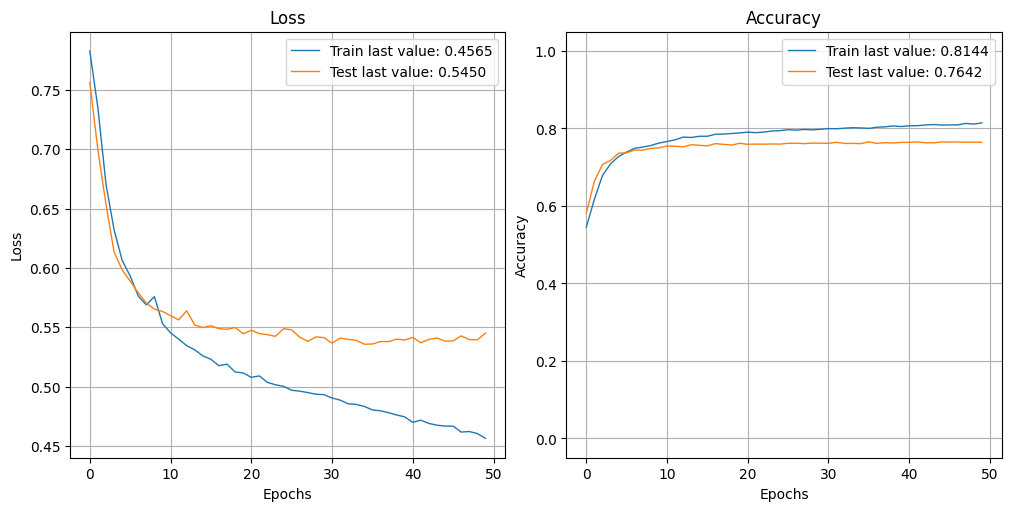

Model loss on the test dataset: 54.50%
Model accuracy on the test dataset: 76.42%


In [ ]:
my_model1(f"{folder_path}best_model2.hdf5",max_words,128,max_len,200,0.7,3,keras.optimizers.RMSprop(learning_rate=0.0001),50)

###Model 2:

In [ ]:
def my_model2(model_name,max_words,output_dim,lstm_units,lstm_dropout,dense_units,optimizer,epochs):
  my_model2 = Sequential()
  my_model2.add(layers.Embedding(max_words, output_dim))
  my_model2.add(layers.LSTM(lstm_units,dropout=lstm_dropout))
  my_model2.add(layers.Dense(dense_units,activation='softmax'))

  my_model2.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

  checkpoint2 = ModelCheckpoint(model_name, monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
  history2 = my_model2.fit(X_train2, y_train2, epochs=epochs,validation_data=(X_test2, y_test2),callbacks=[checkpoint2],batch_size=64)
  #show plot
  showPlot_history(history2)

  # Print out the accuracy of the model on the test set
  model_scores = my_model2.evaluate(X_test2, y_test2, verbose=0)
  print("Model loss on the test dataset: {0:.2f}%".format(model_scores[0]*100))
  print("Model accuracy on the test dataset: {0:.2f}%".format(model_scores[1]*100))

Epoch 1/50
248/250 [============================>.] - ETA: 0s - loss: 0.8253 - accuracy: 0.5153
Epoch 1: val_accuracy improved from -inf to 0.56400, saving model to /content/drive/MyDrive/best_model3.hdf5
250/250 [==============================] - 6s 15ms/step - loss: 0.8246 - accuracy: 0.5155 - val_loss: 0.7805 - val_accuracy: 0.5640
Epoch 2/50
249/250 [============================>.] - ETA: 0s - loss: 0.7761 - accuracy: 0.5442
Epoch 2: val_accuracy did not improve from 0.56400
250/250 [==============================] - 3s 11ms/step - loss: 0.7761 - accuracy: 0.5443 - val_loss: 0.7723 - val_accuracy: 0.5523
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.7634 - accuracy: 0.5760
Epoch 3: val_accuracy improved from 0.56400 to 0.58225, saving model to /content/drive/MyDrive/best_model3.hdf5
250/250 [==============================] - 4s 14ms/step - loss: 0.7634 - accuracy: 0.5760 - val_loss: 0.7560 - val_accuracy: 0.5822
Epoch 4/50
249/250 [========================

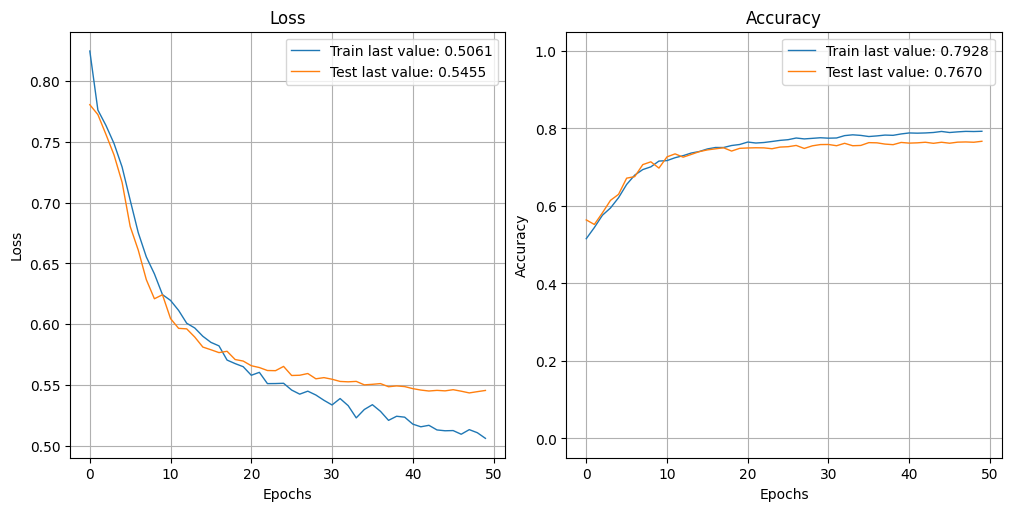

Model loss on the test dataset: 54.55%
Model accuracy on the test dataset: 76.70%


In [ ]:
my_model2(f"{folder_path}best_model3.hdf5",max_words,20,128,0.7,3,keras.optimizers.RMSprop(learning_rate=0.0001),50)

Epoch 1/50
249/250 [============================>.] - ETA: 0s - loss: 0.8055 - accuracy: 0.5173
Epoch 1: val_accuracy improved from -inf to 0.51500, saving model to /content/drive/MyDrive/best_model4.hdf5
250/250 [==============================] - 7s 20ms/step - loss: 0.8052 - accuracy: 0.5174 - val_loss: 0.7787 - val_accuracy: 0.5150
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.7663 - accuracy: 0.5706
Epoch 2: val_accuracy improved from 0.51500 to 0.58625, saving model to /content/drive/MyDrive/best_model4.hdf5
250/250 [==============================] - 4s 17ms/step - loss: 0.7663 - accuracy: 0.5706 - val_loss: 0.7557 - val_accuracy: 0.5863
Epoch 3/50
247/250 [============================>.] - ETA: 0s - loss: 0.7457 - accuracy: 0.5993
Epoch 3: val_accuracy improved from 0.58625 to 0.61775, saving model to /content/drive/MyDrive/best_model4.hdf5
250/250 [==============================] - 4s 17ms/step - loss: 0.7456 - accuracy: 0.5994 - val_loss: 0.7328 - val_

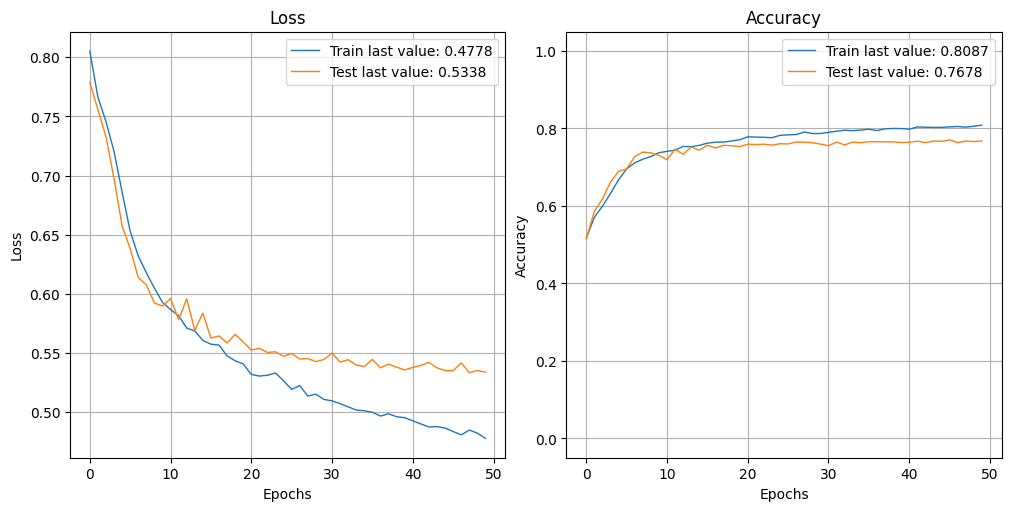

Model loss on the test dataset: 53.38%
Model accuracy on the test dataset: 76.78%


In [ ]:
my_model2(f"{folder_path}best_model4.hdf5",max_words,40,192,0.7,3,keras.optimizers.RMSprop(learning_rate=0.0001),50)

###Model 3 (dodatkowo)

In [ ]:
#Próba uruchomienia modelu z parametrem recurrent_dropout ustawionym na 0.2. Trenowanie 10 epok zajęło ok 37 minut z powodu przekroczenia kryteriów cuDNN (recurrent_dropout>0) przez co moc GPU nie była wykorzystana. Brak widocznej poprawy
my_model3 = Sequential()
my_model3.add(layers.Embedding(max_words, 128))
my_model3.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2))
my_model3.add(layers.Dense(3,activation='softmax'))

my_model3.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint3 = ModelCheckpoint("test_best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history3 = my_model3.fit(X_train2, y_train2,batch_size=32, epochs=10,validation_data=(X_test2, y_test2),callbacks=[checkpoint3])

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.7826 - accuracy: 0.5672
Epoch 1: val_accuracy improved from -inf to 0.58325, saving model to best_model5.hdf5
500/500 [==============================] - 228s 452ms/step - loss: 0.7826 - accuracy: 0.5672 - val_loss: 0.7555 - val_accuracy: 0.5832
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.6657
Epoch 2: val_accuracy improved from 0.58325 to 0.71575, saving model to best_model5.hdf5
500/500 [==============================] - 216s 432ms/step - loss: 0.6887 - accuracy: 0.6657 - val_loss: 0.6426 - val_accuracy: 0.7157
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.7329
Epoch 3: val_accuracy improved from 0.71575 to 0.71700, saving model to best_model5.hdf5
500/500 [==============================] - 218s 437ms/step - loss: 0.6045 - accuracy: 0.7329 - val_loss: 0.6064 - val_accuracy: 0.7170
Epoch 4/10
500/500 [=======================

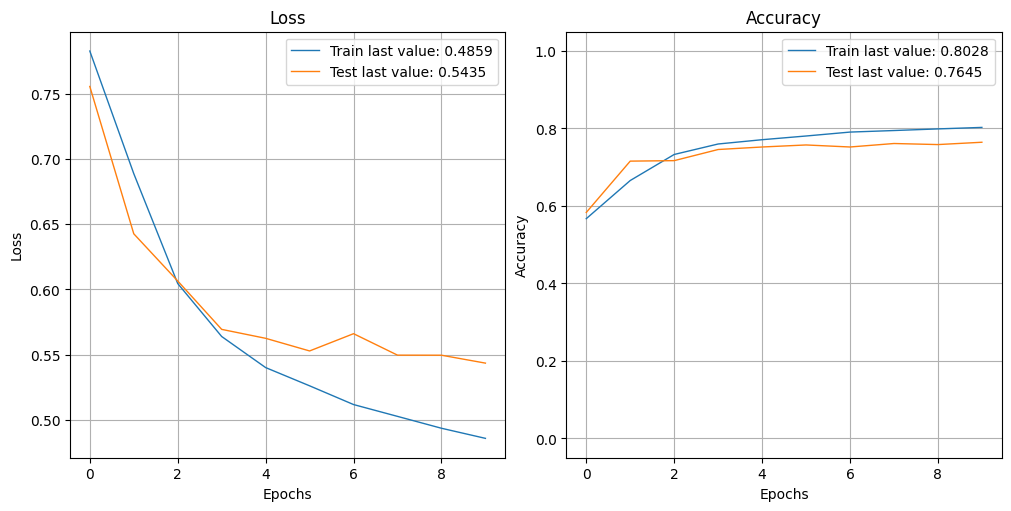

In [ ]:
show_history(history3)
plot_history(history3)
plt.close()

#Etap 4: Language Model

##Ładowanie danych do obiektu dataset

In [14]:
from datasets import Dataset

new_df = predicted_df.rename(columns={'tweetText':'text','predicted':'label'})
new_df['label'] = new_df['label'].replace({-1:0,0:1,1:2}) #Default labels result in erros. Replacing labels to be >0
print(new_df.head())

dataset_ = Dataset.from_pandas(new_df)
dataset = dataset_.train_test_split(0.1)

            tweet created at             tweet id  \
0  2023-05-14 20:05:34+00:00  1657839592010047490   
1  2023-05-14 20:05:27+00:00  1657839561429381120   
2  2023-05-14 20:05:15+00:00  1657839510133022720   
3  2023-05-14 20:05:07+00:00  1657839480575762441   
4  2023-05-14 20:04:13+00:00  1657839253508816898   

                                                text  label  
0  fly city host world s big music contest norfol...      0  
1                                          wanna cry      0  
2  sadly loreen pass good esc winner hate feel to...      0  
3  thrill consider version vocal art form dvorak ...      2  
4  culturally significant renaissance eurovision ...      1  


In [15]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['tweet created at', 'tweet id', 'text', 'label'],
        num_rows: 18000
    })
    test: Dataset({
        features: ['tweet created at', 'tweet id', 'text', 'label'],
        num_rows: 2000
    })
})


In [16]:
print(dataset['test'][0])

{'tweet created at': '2023-05-14 04:21:37+00:00', 'tweet id': 1657602038522613769, 'text': 'congrat loreen make history female artist win pull mae muller dion cooper mia nicolai admit tattoo helluva jam loreen serve vocal', 'label': 2}


##Konfiguracja modelu

In [17]:
model_checkpoint='distilbert-base-uncased'
batch_size=128

In [18]:
from transformers import AutoTokenizer

tokenizer=AutoTokenizer.from_pretrained(model_checkpoint,use_fast=True)

In [19]:
tokenizer("Hello")

{'input_ids': [101, 7592, 102], 'attention_mask': [1, 1, 1]}

In [20]:
dataset['train']

Dataset({
    features: ['tweet created at', 'tweet id', 'text', 'label'],
    num_rows: 18000
})

In [21]:
def process(x):
  return tokenizer(x['text'],padding=True,truncation=True)

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [23]:
dataset_encoded=dataset.map(process,batched=True,batch_size=None)

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [24]:
dataset_encoded['train'].column_names

['tweet created at',
 'tweet id',
 'text',
 'label',
 'input_ids',
 'attention_mask']

In [25]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint,num_labels=3).to("cuda")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [26]:
args = TrainingArguments(
    model_checkpoint,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=float('2e-5'),
    per_device_train_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
    )

In [27]:
import numpy as np
import datasets
metric=datasets.load_metric('glue','sst2')

def compute_metrics(eval_preds):
  logits,labels = eval_preds
  predictions=np.argmax(logits,axis=-1)
  return metric.compute(predictions=predictions,references=labels)

<ipython-input-27-02fe4d33d959>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric=datasets.load_metric('glue','sst2')


In [28]:
trainer = Trainer(model=model,
                  args=args,
                  train_dataset=dataset_encoded['train'],
                  eval_dataset=dataset_encoded['test'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

In [29]:
dataset_encoded['train'].info

DatasetInfo(description='', citation='', homepage='', license='', features={'tweet created at': Value(dtype='string', id=None), 'tweet id': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)

In [30]:
dataset_encoded['train'][1]

{'tweet created at': '2023-05-14 05:25:33+00:00',
 'tweet id': 1657618130158460928,
 'text': 'congratulation loreen talhaoui victory eurovision',
 'label': 2,
 'input_ids': [101,
  26478,
  8609,
  9513,
  19544,
  2368,
  21368,
  3270,
  7140,
  2072,
  3377,
  12714,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1

In [31]:
trainer.evaluate(eval_dataset=[dataset_encoded['train'][1]])

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 1.1314727067947388,
 'eval_accuracy': 0.0,
 'eval_runtime': 4.2089,
 'eval_samples_per_second': 0.238,
 'eval_steps_per_second': 0.238}

Trenowanie modelu

In [32]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.535194,0.759500
2,No log,0.546083,0.764500
3,No log,0.535508,0.781000
4,0.497100,0.527854,0.780500
5,0.497100,0.543267,0.778500


TrainOutput(global_step=705, training_loss=0.4604320877832724, metrics={'train_runtime': 969.0741, 'train_samples_per_second': 92.872, 'train_steps_per_second': 0.727, 'total_flos': 3306569425560000.0, 'train_loss': 0.4604320877832724, 'epoch': 5.0})

In [33]:
trainer.evaluate()

{'eval_loss': 0.5355076789855957,
 'eval_accuracy': 0.781,
 'eval_runtime': 3.7508,
 'eval_samples_per_second': 533.224,
 'eval_steps_per_second': 66.653,
 'epoch': 5.0}

In [34]:
trainer.model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [35]:
trainer.save_model(f"{folder_path}my_distilbert_model/")

In [46]:
preds_output=trainer.predict(dataset_encoded['test'])

In [52]:
preds_output.metrics

{'test_loss': 0.5355076789855957,
 'test_accuracy': 0.781,
 'test_runtime': 7.3278,
 'test_samples_per_second': 272.932,
 'test_steps_per_second': 34.116}

##Testowanie modelu

In [93]:
my_distilbert_model=AutoModelForSequenceClassification.from_pretrained(f"{folder_path}my_distilbert_model/").to("cuda")

In [55]:
import torch

In [94]:
def myBERTclassifier(text):
  classes=['negative','neutral','positive']
  tokens=tokenizer(text)
  tokenlist=[tokens['input_ids']]
  token_torch=torch.tensor(tokenlist).to("cuda")
  output=my_distilbert_model(token_torch)
  
  res=output.logits.argmax().item()
  return classes[res]

In [95]:
myBERTclassifier("I am feeling good!")

'positive'

In [96]:
myBERTclassifier("I hate you!!")

'negative'

In [108]:
for i in range(0,5):
  text=dataset_encoded['test']['text'][i]
  print(text)
  print(myBERTclassifier(text))

congrat loreen make history female artist win pull mae muller dion cooper mia nicolai admit tattoo helluva jam loreen serve vocal
positive
sweden finland croatia come
positive
pay host bbc able realise 20 2 ts twenny
negative
1bluebeanie omg 5 minute vote goodnight sweet dream tattoo
positive
oh yes sexual orientation gay italian
negative


In [109]:
test_list=predicted_df['tweetText'].head(5).to_list()
for el in test_list:
  print(el)
  print(myBERTclassifier(el))

fly city host world s big music contest norfolkflyer100
positive
wanna cry
negative
sadly loreen pass good esc winner hate feel totally understandable
negative
thrill consider version vocal art form dvorak melody testify dvorak rusalka moon song asmik grigorian youtube
positive
culturally significant renaissance eurovision 2023
positive
